In [1]:
!pip install torch==2.2
!pip install torchvision==0.17

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import gc
import math
import matplotlib.pyplot as plt

## Intro

In [3]:
points = torch.tensor([1.0, 4.0, 2.0, 1.0, 3.0, 5.0])
points

tensor([1., 4., 2., 1., 3., 5.])

In [4]:
points.shape

torch.Size([6])

In [5]:
points = torch.tensor([[1.0, 4.0], [2.0, 1.0], [3.0, 5.0]])
points.storage()

<ipython-input-5-aa051972579d>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  points.storage()


 1.0
 4.0
 2.0
 1.0
 3.0
 5.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 6]

In [6]:
points.untyped_storage()

 0
 0
 128
 63
 0
 0
 128
 64
 0
 0
 0
 64
 0
 0
 128
 63
 0
 0
 64
 64
 0
 0
 160
 64
[torch.storage.UntypedStorage(device=cpu) of size 24]

In [7]:
points.size()

torch.Size([3, 2])

In [8]:
points.storage_offset()

0

In [9]:
points[1].storage_offset()

2

In [10]:
points.stride()

(2, 1)

## Data types
PyTorch offers the following data types to be contained within tensors:
* `torch.float32` or `torch.float` - 32-bit floating-point.
* `torch.float64` or `torch.double` - 64-bit, double-precision floating-point.
* `torch.float16` or `torch.half` - 16-bit, half-precision floating-point.
* `torch.int8` - Signed 8-bit integers.
* `torch.uint-8` - Unsigned 8-bit integers.
* `torch.int16` or `torch.short` - Signed 16-bit integers.
* `torch.int32` or `torch.int` - Signed 32-bit integers.
* `torch.int32` or `torch.long` - Signed 64-bit integers.

In [11]:
points = torch.tensor([[1.0, 2.0], [3.0, 4.0]], dtype=torch.float32, device='cpu')
points

tensor([[1., 2.],
        [3., 4.]])

In [12]:
# points = points.to(device='cuda')

In [13]:
points.is_cuda

False

In [14]:
points

tensor([[1., 2.],
        [3., 4.]])

In [15]:
points = points.to(device='cpu')

In [16]:
points.is_cuda

False

In [17]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## PyTorch Modules
### a) `torch.nn`

In [18]:
weights = torch.randn(256, 4) / math.sqrt(256)
weights

tensor([[-0.0057, -0.0494, -0.0140,  0.0036],
        [-0.0210, -0.0818,  0.0366,  0.0356],
        [ 0.0396,  0.0517, -0.0301,  0.0713],
        ...,
        [ 0.0731,  0.0497, -0.1134,  0.0504],
        [-0.0613,  0.0301, -0.0857, -0.0681],
        [ 0.0020, -0.0513,  0.0038, -0.0422]])

In [19]:
# We then ensure that the parameters of this neural network are trainable, that is, the numbers in the 256x4 matrix can be
# tuned with the help of back propagation.
weights.requires_grad_()

tensor([[-0.0057, -0.0494, -0.0140,  0.0036],
        [-0.0210, -0.0818,  0.0366,  0.0356],
        [ 0.0396,  0.0517, -0.0301,  0.0713],
        ...,
        [ 0.0731,  0.0497, -0.1134,  0.0504],
        [-0.0613,  0.0301, -0.0857, -0.0681],
        [ 0.0020, -0.0513,  0.0038, -0.0422]], requires_grad=True)

In [20]:
# Finally we also add the bias weights for the 4-dimensiona output, and make these trainable too
bias = torch.zeros(4, requires_grad=True)
bias

tensor([0., 0., 0., 0.], requires_grad=True)

In [21]:
# We can instead use nn.Linear(256, 4) to represent the same thing in PyTorch
nn.Linear(256, 4)

Linear(in_features=256, out_features=4, bias=True)

In [22]:
#loss_funct = F.cross_entropy
#loss = loss_funct(model(X), y)

### b) `torch.optim`

In [23]:
#opt = optim.SGD(model.parameters(), lr=lr)

### c) `torch.utils.data`

## Training a Neural Network using PyTorch
### a) Define Model Architecture

![ConvNet](https://github.com/dancodermachine/mastering_pytorch_v2/blob/main/images/chap1_cnn.png?raw=True)

In [24]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.cn1 = nn.Conv2d(1, 16, 3, 1)
    self.cn2 = nn.Conv2d(16, 32, 3, 1)
    self.dp1 = nn.Dropout2d(0.10)
    self.dp2 = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.cn1(x)
    x = F.relu(x)
    x = self.cn2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dp1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dp2(x)
    x = self.fc2(x)
    op = F.log_softmax(x, dim=1)
    return op

## b) Define Training and Inference Routines

In [25]:
def train(model, device, train_dataloader, optim, epoch):
  model.train()
  for b_i, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    optim.zero_grad()
    pred_prob = model(X)
    loss = F.nll_loss(pred_prob, y)
    loss.backward()
    optim.step()
    if b_i % 10 == 0:
      print("Epoch: {} [{}/{} ({:.0f}%)]\t training loss {:.6f}".format(epoch,
                                                                        b_i * len(X), # Instances
                                                                        len(train_dataloader.dataset),
                                                                        100. * b_i / len(train_dataloader),
                                                                        loss.item()))

In [26]:
def test(model, device, test_dataloader):
  model.eval()
  loss = 0
  success = 0
  with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      pred_prob = model(X)
      loss += F.nll_loss(pred_prob, y, reduction='sum').item() # Loss summed across the batch
      pred = pred_prob.argmax(dim=1, keepdim=True) # Use argmax to get the most likely prediction
      success += pred.eq(y.view_as(pred)).sum().item()

  loss /= len(test_dataloader.dataset)

  print("\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n".format(loss,
                                                                                           success,
                                                                                           len(test_dataloader.dataset),
                                                                                           100. * success / len(test_dataloader.dataset)))

### c) Create Data Loaders

In [27]:
# The mean and std values are calculated as the mean of all pixel values of all images in the training dataset.
train_dataloader = torch.utils.data.DataLoader(datasets.MNIST("../data",
                                                              train=True,
                                                              download=True,
                                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                                            transforms.Normalize((0.1302),
                                                                                                                 (0.3069))])),
                                               batch_size=32,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(datasets.MNIST("../data",
                                                             train=False,
                                                             transform=transforms.Compose([transforms.ToTensor(),
                                                                                           transforms.Normalize((0.1302),
                                                                                                                (0.3069))])),
                                              batch_size=512,
                                              shuffle=False)

### d) Define Optimizer and Run Training Epochs

In [28]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

### e) Model Training

In [29]:
for epoch in range(1, 3):
  train(model, device, train_dataloader, optimizer, epoch)
  test(model, device, test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 [0/60000 (0%)]	 training loss 2.310609
Epoch: 1 [320/60000 (1%)]	 training loss 1.924133
Epoch: 1 [640/60000 (1%)]	 training loss 1.313336
Epoch: 1 [960/60000 (2%)]	 training loss 0.796470
Epoch: 1 [1280/60000 (2%)]	 training loss 0.819801
Epoch: 1 [1600/60000 (3%)]	 training loss 0.678430
Epoch: 1 [1920/60000 (3%)]	 training loss 0.477187
Epoch: 1 [2240/60000 (4%)]	 training loss 0.529062
Epoch: 1 [2560/60000 (4%)]	 training loss 0.468829
Epoch: 1 [2880/60000 (5%)]	 training loss 0.242887
Epoch: 1 [3200/60000 (5%)]	 training loss 0.519633
Epoch: 1 [3520/60000 (6%)]	 training loss 0.262872
Epoch: 1 [3840/60000 (6%)]	 training loss 0.467795
Epoch: 1 [4160/60000 (7%)]	 training loss 0.417298
Epoch: 1 [4480/60000 (7%)]	 training loss 0.316030
Epoch: 1 [4800/60000 (8%)]	 training loss 0.498437
Epoch: 1 [5120/60000 (9%)]	 training loss 0.157880
Epoch: 1 [5440/60000 (9%)]	 training loss 0.364403
Epoch: 1 [5760/60000 (10%)]	 training loss 0.085984
Epoch: 1 [6080/60000 (10%)]	 trainin

In [30]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### f) Run Inference on Trained Model

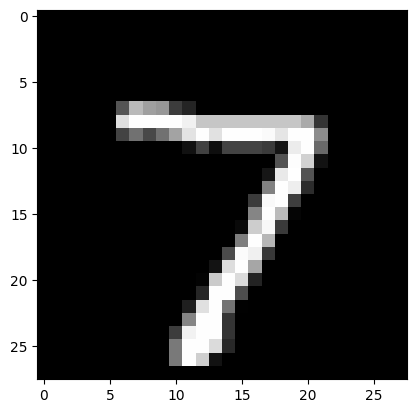

In [31]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [32]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7


Reference:
* https://github.com/arj7192/MasteringPyTorchV2/tree/main/Chapter01